# Sentinel 5P Atmospheric Gas Timeseries Tool

## Overview
This Jupyter notebook will allow you to monitor the atmosphere above a landfill on a daily basis for the following gasses:
- Methane (CH4)
- Nitrogen dioxide (NO2)
- Carbon monoxide (CO)
- Formaldehyde (HCHO)
- Ozone (O3)
- Sulfur dioxide (SO2)

Please run the code in order and follow any instructions given. Should you have any problems, please refer to the relevant section in the user manual. 

The section below imports the packages needed to run the script.

In [1]:
import folium  # Importing GeoJson class from folium library for visualizing geospatial data
import pandas as pd  # Importing pandas library and aliasing it as pd for data analysis and manipulation
import matplotlib.pyplot as plt  # Importing pyplot module from matplotlib library and aliasing it as plt for plotting
import scipy.signal  # Importing signal module from scipy library for signal processing
import numpy as np  # Importing numpy library and aliasing it as np for numerical computing
import geopandas as gpd  # Importing geopandas library and aliasing it as gpd for working with geographic data
import openeo  # Importing openeo library for working with the OpenEO API for Earth Observation data processing
from shapely.geometry import shape  # Importing shape class from geometry module of shapely library for geometric operations

## Connect to OpenEO

The code below establishes a connection with the Copernicus openEO platform which provides a wide variety of earth observation datasets

- If this does not read as 'Authorised successfully' or 'Authenticated using refresh token', then please ensure that you have completed the setup steps as outlined in section (section goes here) of the user guide. 

- If you have followed the steps in section (section goes here) correctly and the problem persists, please look at https://dataspace.copernicus.eu/news for any information about service interruptions. 

- If there is no news of service problems you can raise a ticket here: https://helpcenter.dataspace.copernicus.eu/hc/en-gb/requests/new

In [2]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

## View list of landfills. 

For easy reference the complete list of landfills can be viewed by running the following piece of code.

In [3]:
landfills = gpd.read_file(r"C:\GIS_Course\Landfill_Atmospheric_Gas_Monitor_Tools\Data\PZ_landfill_point4326.geojson")

landfills

,Landfill,Lat,Long,geometry
0,ALBACETE,38.994590,-1.776850,POINT (-1.77685 38.99459)
1,ALBOX: MANCOMUNIDAD ALMANZORA LEVANTE,37.390644,-2.173969,POINT (-2.17397 37.39064)
2,ALCAL� DEL R�O (LA VEGA-SEVILLA),37.599190,-5.999450,POINT (-5.99945 37.59919)
3,ALC�ZAR DE SAN JUAN (COMPLEJO): COMSERMANCHA,39.432932,-3.225099,POINT (-3.22510 39.43293)
4,ALMER�A: CMA,36.878879,-2.286746,POINT (-2.28675 36.87888)
5,CAN MATA (ELS HOSTALETS DE PIEROLA): DC,41.530854,1.806387,POINT (1.80639 41.53085)
6,CA�ADA HERMOSA: MURCIA,37.980683,-1.288079,POINT (-1.28808 37.98068)
7,DAIMIEL,39.064526,-3.584598,POINT (-3.58460 39.06453)
8,ECOPARQUE DE TOLEDO: GESMAT,39.861188,-4.163804,POINT (-4.16380 39.86119)
9,ECOPARQUE GRAN CANARIA NORTE (SALTO DEL NEGRO),28.058762,-15.423571,POINT (-15.42357 28.05876)


## View location of landfills. 

This section displays a map of all the landfill sites. Click any site for its name. 

NOTE: the warning "...Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect..." can be ignored. 

In [4]:
# This creates the map and centres it on the geometries. 
centroids = landfills.geometry.centroid
centre = [centroids.y.mean(), centroids.x.mean()]
site_map = folium.Map(location=centre, zoom_start=5)

# Adding the landfill locations to the map
for feature in landfills.iterfeatures():
    # Extract feature number from properties
    feature_number = feature['properties']['Landfill'] #this is for the PreZero ones
    
    # Extract coordinates of the feature
    coordinates = feature['geometry']['coordinates']
    
    # Create a marker with label for each feature
    folium.Marker(location=[coordinates[1], coordinates[0]], 
                  popup=f"Feature {feature_number}").add_to(site_map)

# Display the map
site_map

C:\Users\kinse\AppData\Local\Temp\ipykernel_13432\790790625.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = landfills.geometry.centroid


## Adding 10,000 metre radius buffer to landfills 

Because gas exists as a cloud above the site, the area around the landfill is as important to minitor as the air directly above it. This section applies a buffer of 10,000m to each landfill for the analysis.

In [5]:
# loading dataframe
landfill_10000m = landfills

# The dataset is projected in EPSG:4326 with its units in degrees. This needs to be converted to CRS to EPSG:2062, which is in metres. 
landfill_10000m = landfill_10000m.to_crs(epsg=2062)

# Now the dataframe is converted, a buffer of 5000m is added to each point
landfill_10000m['geometry'] = landfill_10000m.buffer(10000)

# Now the buffered data needs to be converted back to EPSG:4326 because the Sentinel data is projected in EPSG:4326.
landfill_10000m = landfill_10000m.to_crs(epsg=4326)

# The time series analysis requires that A GeoJSON format file is used for the analised areas, so this bit produces a file suitable for that.
landfill_10000m_geojson = landfill_10000m.__geo_interface__

# Choose date range and gas type
Here you can to choose the range of dates you wish to analise and the gas type to be monitored. 

The two parameters you need to modify before running the code are: 
- temporal_extent = ["2023-01-31", "2023-03-12"] (change this to your chosen date range using "YYYY-MM-DD" format)
- bands=["CH4"], (change this to either one of 'CO', 'HCHO', 'NO2', 'O3', 'SO2', 'CH4')

In [7]:
s5cube_timeseries = connection.load_collection(
    "SENTINEL_5P_L2",  
    temporal_extent=["2023-01-01", "2023-01-31"], # Select a date range using the format YYYY-MM-DD
    bands=["CH4"], 
)

## Running the Analysis
Here, no modification by you is needed. The code below runs the analysis. 

NOTE: This analysis will take several minutes to complete, when I ran the tool, it took aproximately 5 minutes for one month of data and 8 minutes for two months. Your milage may vary.

Should you wish to view the data in a spreasheet, a .CSV file will be created where the prompt "job.get_results().download_file" indicates.

In [8]:
timeseries = s5cube_timeseries.aggregate_spatial(geometries=landfill_10000m_geojson, reducer="mean")

#This saves the results as a .CSV file which can be viewed in Microsoft Excel or a similar package. It will be saved in the indicated location.
job = timeseries.execute_batch(out_format="CSV", title="Gas timeseries")

job.get_results().download_file("Gas_Timeseries_results/Gas_timeseries.csv")

pd.read_csv("Gas_Timeseries_results/Gas_timeseries.csv", index_col=0)

0:00:00 Job 'j-24051041cf144bbb8e77a0759c7c0ac5': send 'start'
0:03:35 Job 'j-24051041cf144bbb8e77a0759c7c0ac5': running (progress N/A)
0:04:39 Job 'j-24051041cf144bbb8e77a0759c7c0ac5': error (progress N/A)
Your batch job 'j-24051041cf144bbb8e77a0759c7c0ac5' failed. Error logs:
[{'id': '[1715330275119, 978614]', 'time': '2024-05-10T08:37:55.119Z', 'level': 'error', 'message': "OpenEO batch job failed: KazooTimeoutError('Connection time-out')"}]
Full logs can be inspected in an openEO (web) editor or with `connection.job('j-24051041cf144bbb8e77a0759c7c0ac5').logs()`.


JobFailedException: Batch job 'j-24051041cf144bbb8e77a0759c7c0ac5' didn't finish successfully. Status: error (after 0:05:59).

## Display the data on a chart. 

Please run the code below to display your analised data on a chart. 

If you only want to see data for a selection of landfills you can modify the following perameter:
- selected_landfill_ids=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

WARNING: Viewing more than 10 landfills at a time isn't recommended as the datapoint colours repeat for more than 10 values. 

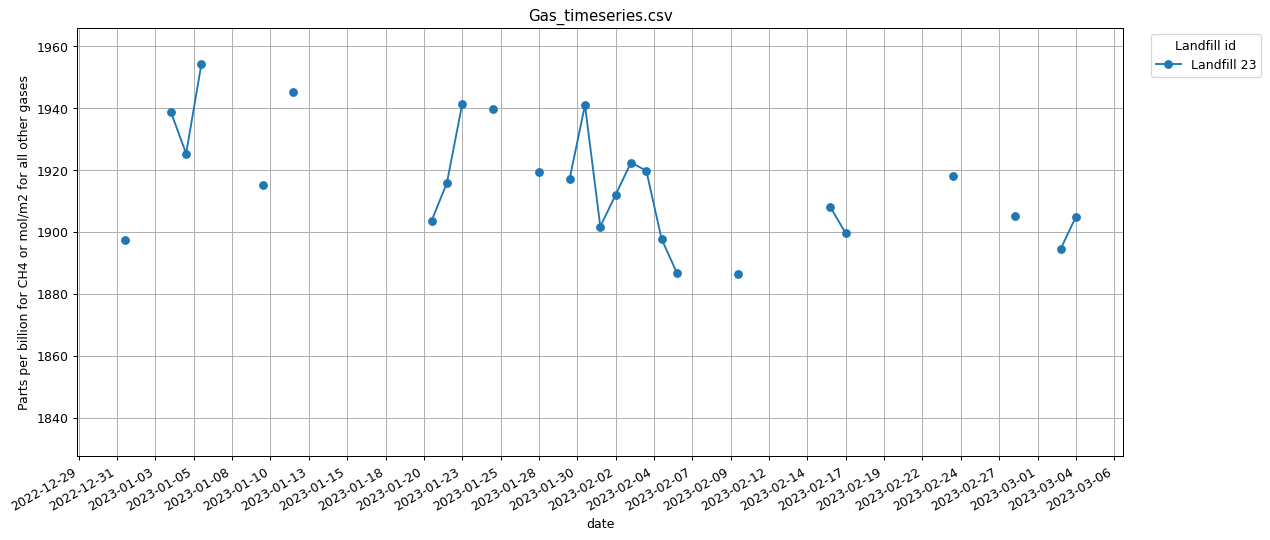

In [19]:
def plot_timeseries(filename, selected_landfill_ids=None, figsize=(15, 7)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    fig, ax = plt.subplots(figsize=figsize, dpi=90)

    if selected_landfill_ids:
        df_selected = df[df['feature_index'].isin(selected_landfill_ids)]
        for landfill_id, group in df_selected.groupby("feature_index"):
            group["avg(band_0)"].plot(marker="o", label=f"Landfill {landfill_id}", ax=ax)
    else:
        df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)

    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("Parts per billion for CH4 or mol/m2 for all other gases")

    ymin = df["avg(band_0)"].min()
    ymax = df["avg(band_0)"].max()
    ymin_with_margin = ymin - 0.1 * (ymax - ymin)
    ymax_with_margin = ymax + 0.1 * (ymax - ymin)
    ax.set_ylim(ymin_with_margin, ymax_with_margin)

    ax.legend(title="Landfill id", loc='upper left', bbox_to_anchor=(1.02, 1), ncol=2)
    ax.xaxis.set_major_locator(plt.MaxNLocator(30))
    ax.grid(True)

# Change the selected landfill ids for the ones you want to view.
plot_timeseries("Gas_Timeseries_results/Gas_timeseries.csv", 
                
                selected_landfill_ids=[23])


## Interpreting this graph

- CH4 measurements are column averaged dry air mixing ratio of methane (parts per billion). Ranges of 1,600 - 2,000
- NO2 measurements are Nitrogen dioxide tropospheric column (mol/m2). Ranges of 0 - 0.0003
- CO measurements are Carbon monoxide total column (mol/m2). Ranges of 0 - 0.1
- HCHO measurements are Formaldehyde troposheric vertical column (mol/m2). Ranges of 0 - 0.001
- O3 measurements are Ozone total column (mol/m2). Ranges of 0 - 0.36
- SO2 measurements are Sulfur dioxide total column (mol/m2). Ranges of 0 - 0.01

More information: https://docs.sentinel-hub.com/api/latest/data/sentinel-5p-l2/